In [ ]:
!pip install ConfigSpace
import ConfigSpace
import matplotlib.pyplot as plt
import numpy as np
import keras
import time
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ConfigSpace: filename=ConfigSpace-1.2.0-py3-none-any.whl size=115855 sha256=ba2543e941500a8d12ef67d5e883b9c95b7e0e9bd1837c43db8cce823be05dbc
  Stored in directory: /root/.cache/pip/wheels/5f/1f/4b/450c9c9d1ede888e354984d9eba7e60f13878fa079d502d52e
Successfully built ConfigSpace


# 1.Random Search on MLP

After comparing different hyperparameters, we use random search to find 3 best-performing hyperparameter sets by constraining hyperparameters within a certain range.

Build up configuration space.

In [ ]:

def get_hyperparameter_search_space():

    cs = ConfigSpace.ConfigurationSpace()
    learning_rate = ConfigSpace.UniformFloatHyperparameter("learning_rate", 1e-5, 0.0001, log=True, default_value=0.0001)
    dropout = ConfigSpace.CategoricalHyperparameter(name='dropout', choices=['t', 'f'], default_value='f')
    keep_prop_rate = ConfigSpace.UniformFloatHyperparameter('keep_prop_rate', lower=0.1, upper=0.5, default_value=0.1, log=False)
    regularization = ConfigSpace.CategoricalHyperparameter(name='regularization', choices=['t', 'f'], default_value='f')
    regularization_param = ConfigSpace.UniformFloatHyperparameter('regularization_param',0.0001 , 0.001, log=True, default_value=0.0001)

    batch_size = ConfigSpace.UniformIntegerHyperparameter('batch_size', 16, 128, default_value=128)
    layer_num = ConfigSpace.UniformIntegerHyperparameter('layer_num', 1, 10, default_value=3)
    dense_num = ConfigSpace.UniformIntegerHyperparameter('dense_num', 10, 500, default_value=300)
    #lay_num = ConfigSpace.UniformIntegerHyperparameter('lay_num', 2, 10, default_value=3)
    kernel_initializer = ConfigSpace.CategoricalHyperparameter('kernel_initializer', ['he_uniform', 'he_normal', 'glorot_uniform'], default_value='he_uniform')
    optimizer = ConfigSpace.CategoricalHyperparameter('optimizer', ['rmsprop', 'sgd', 'adam'], default_value='adam')

    cs.add([batch_size, dense_num, layer_num, learning_rate, regularization_param, dropout,
            keep_prop_rate, regularization, kernel_initializer, optimizer])

    re_depends_on_regularization = ConfigSpace.EqualsCondition(regularization_param, regularization, 't')
    rate_depends_on_dropout = ConfigSpace.EqualsCondition(keep_prop_rate, dropout, 't')
    cs.add(re_depends_on_regularization)
    cs.add(rate_depends_on_dropout)


    return cs

ERROR! Session/line number was not unique in database. History logging moved to new session 2


Build up model.

In [ ]:
class Model():
    def __init__(self, config, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.config = config
        self.num = 10
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.optimizer = None
        self.model = self.compute()
    def evaluate(self):
        performance = self.model.evaluate(self.X_test, self.y_test)[1]
        return performance
    def compute(self):
        model = keras.models.Sequential()
        model.add(keras.layers.Dropout(self.config['keep_prop_rate']))
        model.add(keras.layers.Flatten(input_shape=[28, 28]))
        for _ in range(self.config['layer_num']):
            if self.config['dropout'] == 't':
                model.add(keras.layers.Dropout(self.config['keep_prop_rate']))
            if self.config['regularization'] == 't':
                dense_num = int(np.random.random()*self.config['dense_num'])
                model.add(keras.layers.Dense(dense_num,
                                             activation='relu',
                                             kernel_initializer=self.config['kernel_initializer'],
                                             kernel_regularizer=keras.regularizers.l2(self.config['regularization_param'])))
            else:
                dense_num = int(np.random.random()*self.config['dense_num'])
                model.add(keras.layers.Dense(dense_num,
                                             activation='relu',
                                             kernel_initializer=self.config['kernel_initializer']))
        model.add(keras.layers.Dropout(self.config['keep_prop_rate']))
        model.add(keras.layers.Dense(10, activation="softmax"))
        if self.config['optimizer']=='rmsprop':
            self.optimizer = keras.optimizers.RMSprop(learning_rate=self.config['learning_rate'])
        if self.config['optimizer']=='adam':
            self.optimizer = keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        else:
            self.optimizer = keras.optimizers.SGD(learning_rate=self.config['learning_rate'])

        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        model.fit(self.X_train, self.y_train, batch_size=self.config['batch_size'],
                  epochs=50, validation_data=(self.X_valid, self.y_valid))
        return model
def default(cs, configs):
      for hp in list(cs.values()):
            if hp.name not in configs.keys():
                configs[hp.name] = hp.default_value


Randomly sample configuration to train the model.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1)

cs = get_hyperparameter_search_space()

best_configs = []
best_performances = []
best_model = []
iteration_num = 50
for i in range(3):
    best_performance = -np.inf
    best_config = {}
    for j in range(iteration_num):
    
        config = dict(cs.sample_configuration(size=None))
        default(cs, config)
        model = Model(config, X_train, y_train, X_valid, y_valid, X_test, y_test)
        performance = model.evaluate()
        if performance>best_performance:
            best_config = config
            best_performance = performance
    best_model.append(model)
    best_performances.append(best_performance)
    best_configs.append(best_config)
for i in range(len(best_configs)):
    print(best_configs[i])
print(best_performances)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.1015 - loss: 5.3629 - val_accuracy: 0.1810 - val_loss: 2.2312
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1020 - loss: 5.0847 - val_accuracy: 0.1895 - val_loss: 2.2082
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1024 - loss: 4.9202 - val_accuracy: 0.1920 - val_loss: 2.1934
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1037 - loss: 4.8200 - val_accuracy: 0.1953 - val_loss: 2.1817
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1072 - loss: 4.7098 - val_accuracy: 0.2005 - val_loss: 2.1713
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1045 - loss: 4.6147 - val_accuracy: 0.2067 - val_loss: 2.1617
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1056 - loss: 4.5295 - val_accuracy: 0.2108 - val_loss: 2.1531
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1060 - loss: 4.4854 - val_accuracy: 

I0000 00:00:1730564355.443138     128 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



667/667 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.3913 - loss: 2.1721 - val_accuracy: 0.7563 - val_loss: 1.1244
Epoch 2/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7293 - loss: 1.2245 - val_accuracy: 0.7982 - val_loss: 1.0057
Epoch 3/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7779 - loss: 1.0944 - val_accuracy: 0.8220 - val_loss: 0.9545
Epoch 4/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8003 - loss: 1.0300 - val_accuracy: 0.8392 - val_loss: 0.9008
Epoch 5/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8108 - loss: 0.9855 - val_accuracy: 0.8427 - val_loss: 0.8767
Epoch 6/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8223 - loss: 0.9464 - val_accuracy: 0.8487 - val_loss: 0.8563
Epoch 7/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8294 - loss: 0.9177 - val_accuracy: 0.8563 - val_loss: 0.8330
Epoch 8/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8356 - loss: 0.8884 - val_accuracy: 0.8582 - va

I0000 00:00:1730564510.532983     129 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_3', 8 bytes spill stores, 8 bytes spill loads



422/422 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.1035 - loss: 2.2961 - val_accuracy: 0.1375 - val_loss: 2.2521
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1327 - loss: 2.2068 - val_accuracy: 0.1997 - val_loss: 2.1309
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1854 - loss: 2.1060 - val_accuracy: 0.1960 - val_loss: 2.0514
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1992 - loss: 1.9948 - val_accuracy: 0.2193 - val_loss: 1.9212
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2164 - loss: 1.8833 - val_accuracy: 0.2227 - val_loss: 1.8819
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2283 - loss: 1.8304 - val_accuracy: 0.1703 - val_loss: 1.9124
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2511 - loss: 1.7663 - val_accuracy: 0.1592 - val_loss: 1.8869
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2661 - loss: 1.7100 - val_accuracy: 0.1800 - va

I0000 00:00:1730564954.454588     129 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



594/594 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3585 - loss: 2.0857 - val_accuracy: 0.7132 - val_loss: 1.0312
Epoch 2/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7140 - loss: 1.0344 - val_accuracy: 0.7860 - val_loss: 0.8498
Epoch 3/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7792 - loss: 0.8694 - val_accuracy: 0.8032 - val_loss: 0.7737
Epoch 4/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8038 - loss: 0.7926 - val_accuracy: 0.8270 - val_loss: 0.7198
Epoch 5/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.7443 - val_accuracy: 0.8310 - val_loss: 0.6910
Epoch 6/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8259 - loss: 0.7144 - val_accuracy: 0.8423 - val_loss: 0.6693
Epoch 7/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8338 - loss: 0.6870 - val_accuracy: 0.8470 - val_loss: 0.6456
Epoch 8/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8355 - loss: 0.6715 - val_accuracy: 0.8527 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3027
Epoch 46/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1003 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3027
Epoch 47/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1032 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3027
Epoch 48/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0989 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3028
Epoch 49/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1000 - loss: 2.3026 - val_accuracy: 0.0920 - val_loss: 2.3028
Epoch 50/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1030 - loss: 2.3025 - val_accuracy: 0.0920 - val_loss: 2.3028
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1056 - loss: 2.3025
Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.0973 - loss: 3.4007 - val_accuracy: 0.0552 - val_loss: 3.2880
Epoch 2/50
844/844 ━━

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1641 - loss: 2.2275 - val_accuracy: 0.1508 - val_loss: 2.2490
Epoch 5/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1898 - loss: 2.1549 - val_accuracy: 0.1612 - val_loss: 2.1914
Epoch 6/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1968 - loss: 2.0932 - val_accuracy: 0.1470 - val_loss: 2.1496
Epoch 7/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2049 - loss: 2.0285 - val_accuracy: 0.1152 - val_loss: 2.1093
Epoch 8/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2161 - loss: 1.9702 - val_accuracy: 0.1138 - val_loss: 2.0772
Epoch 9/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2207 - loss: 1.9320 - val_accuracy: 0.1118 - val_loss: 2.0519
Epoch 10/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2340 - loss: 1.8957 - val_accuracy: 0.1113 - val_loss: 2.0339
Epoch 11/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2400 - loss: 1.8566 - val_accur

I0000 00:00:1730569971.127869     126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_3', 8 bytes spill stores, 8 bytes spill loads



1228/1228 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.1428 - loss: 2.3230 - val_accuracy: 0.4142 - val_loss: 1.7417
Epoch 2/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3955 - loss: 1.6873 - val_accuracy: 0.5283 - val_loss: 1.2742
Epoch 3/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4952 - loss: 1.3813 - val_accuracy: 0.5673 - val_loss: 1.1297
Epoch 4/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5393 - loss: 1.2517 - val_accuracy: 0.6245 - val_loss: 1.0381
Epoch 5/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5820 - loss: 1.1598 - val_accuracy: 0.6858 - val_loss: 0.9679
Epoch 6/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6205 - loss: 1.0782 - val_accuracy: 0.7297 - val_loss: 0.9095
Epoch 7/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6520 - loss: 1.0172 - val_accuracy: 0.7437 - val_loss: 0.8563
Epoch 8/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6857 - loss: 0.9630 - val_accur

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1118 - loss: 2.3571 - val_accuracy: 0.1112 - val_loss: 2.3547
Epoch 24/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1096 - loss: 2.3566 - val_accuracy: 0.1145 - val_loss: 2.3539
Epoch 25/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1138 - loss: 2.3559 - val_accuracy: 0.1178 - val_loss: 2.3530
Epoch 26/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1159 - loss: 2.3552 - val_accuracy: 0.1203 - val_loss: 2.3520
Epoch 27/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1139 - loss: 2.3541 - val_accuracy: 0.1253 - val_loss: 2.3510
Epoch 28/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1193 - loss: 2.3530 - val_accuracy: 0.1307 - val_loss: 2.3499
Epoch 29/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1216 - loss: 2.3522 - val_accuracy: 0.1358 - val_loss: 2.3487
Epoch 30/50
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1258 - loss: 2.3511 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1010 - loss: 2.3660 - val_accuracy: 0.1093 - val_loss: 2.3382
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1018 - loss: 2.3673 - val_accuracy: 0.1093 - val_loss: 2.3382
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1012 - loss: 2.3646 - val_accuracy: 0.1092 - val_loss: 2.3382
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1005 - loss: 2.3656 - val_accuracy: 0.1092 - val_loss: 2.3382
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0999 - loss: 2.3612 - val_accuracy: 0.1033 - val_loss: 2.3382
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0991 - loss: 2.3625 - val_accuracy: 0.1033 - val_loss: 2.3382
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0985 - loss: 2.3605 - val_accuracy: 0.1033 - val_loss: 2.3382
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0991 - loss: 2.3598 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2455/2455 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5363 - loss: 2.1817 - val_accuracy: 0.6035 - val_loss: 2.0773
Epoch 17/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5479 - loss: 2.1368 - val_accuracy: 0.6092 - val_loss: 2.0371
Epoch 18/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5553 - loss: 2.1015 - val_accuracy: 0.6160 - val_loss: 1.9995
Epoch 19/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5686 - loss: 2.0580 - val_accuracy: 0.6205 - val_loss: 1.9641
Epoch 20/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5703 - loss: 2.0327 - val_accuracy: 0.6270 - val_loss: 1.9309
Epoch 21/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5740 - loss: 2.0000 - val_accuracy: 0.6302 - val_loss: 1.9000
Epoch 22/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5860 - loss: 1.9635 - val_accuracy: 0.6372 - val_loss: 1.8710
Epoch 23/50
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5868 - loss: 1.9402 - val_

{'batch_size': 81, 'dense_num': 497, 'dropout': 't', 'kernel_initializer': 'he_uniform', 'layer_num': 7, 'learning_rate': 7.53568583e-05, 'optimizer': 'adam', 'regularization': 't', 'keep_prop_rate': 0.1180346539385, 'regularization_param': 0.0001208036847}



{'batch_size': 45, 'dense_num': 254, 'dropout': 'f', 'kernel_initializer': 'he_uniform', 'layer_num': 6, 'learning_rate': 8.17295463e-05, 'optimizer': 'adam', 'regularization': 'f', 'keep_prop_rate': 0.1, 'regularization_param': 0.0001}



{'batch_size': 104, 'dense_num': 213, 'dropout': 'f', 'kernel_initializer': 'glorot_uniform', 'layer_num': 10, 'learning_rate': 5.04320814e-05, 'optimizer': 'adam', 'regularization': 't', 'regularization_param': 0.0002345882678, 'keep_prop_rate': 0.1}



[0.8888000249862671, 0.8906999826431274, 0.8892999887466431]

In [ ]:
best_model[0].model.summary()


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_417 (Dropout)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_83 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_418 (Dropout)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 115)            │        90,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_419 (Dropout)           │ (None, 115)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 155)            │        17,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_420 (Dropout)           │ (None, 155)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_539 (Dense)               │ (None, 10)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,447 (1.26 MB)

 Trainable params: 109,815 (428.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 219,632 (857.94 KB)

Next, using these three configurations to train new models on the CIFAR-10 dataset

1. import CIFAR-10 dataset.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32')/255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Split into validation set

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [7]:
y_train = keras.utils.to_categorical(y_train, 10)
y_val= keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_train.shape)

(40000, 10)


Set model to the best configurations.

In [8]:
config_data =[
    {'batch_size': 81, 'dense_num': 497, 'dropout': 't', 'kernel_initializer': 'he_uniform', 'layer_num': 7, 'learning_rate': 7.53568583e-05, 'optimizer': 'adam', 'regularization': 't', 'keep_prop_rate': 0.1180346539385, 'regularization_param': 0.0001208036847},
    {'batch_size': 45, 'dense_num': 254, 'dropout': 'f', 'kernel_initializer': 'he_uniform', 'layer_num': 6, 'learning_rate': 8.17295463e-05, 'optimizer': 'adam', 'regularization': 'f', 'keep_prop_rate': 0.1, 'regularization_param': 0.0001},
    {'batch_size': 104, 'dense_num': 213, 'dropout': 'f', 'kernel_initializer': 'glorot_uniform', 'layer_num': 10, 'learning_rate': 5.04320814e-05, 'optimizer': 'adam', 'regularization': 't', 'regularization_param': 0.0002345882678, 'keep_prop_rate': 0.1}
]

Build up model.

In [ ]:
history={}
for i, config in enumerate(config_data):
  model = keras.models.Sequential()
  model.add(keras.layers.Dropout(config['keep_prop_rate']))
  model.add(keras.layers.Flatten(input_shape=[32,32,3]))
  for _ in range(config['layer_num']):
      if config['dropout'] == 't':
          model.add(keras.layers.Dropout(config['keep_prop_rate']))
      if config['regularization'] == 't':
          dense_num = int(np.random.random()*config['dense_num'])
          model.add(keras.layers.Dense(dense_num,activation='relu',kernel_initializer=config['kernel_initializer'],
              kernel_regularizer=keras.regularizers.l2(config['regularization_param'])))
      else:
          dense_num = int(np.random.random()*config['dense_num'])
          model.add(keras.layers.Dense(dense_num,activation='relu', kernel_initializer=config['kernel_initializer']))
  model.add(keras.layers.Dropout(config['keep_prop_rate']))
  model.add(keras.layers.Dense(10, activation="softmax"))
  if config['optimizer']=='rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
  if config['optimizer']=='adam':
    optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])
  else:
    optimizer = keras.optimizers.SGD(learning_rate=config['learning_rate'])

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  history[i]=model.fit(x_train, y_train, batch_size=config['batch_size'],
            epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.0990 - loss: 47.3755 - val_accuracy: 0.1026 - val_loss: 2.5734
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1019 - loss: 3.1265 - val_accuracy: 0.1030 - val_loss: 2.5730
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1005 - loss: 2.6838 - val_accuracy: 0.1030 - val_loss: 2.5728
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1014 - loss: 2.6106 - val_accuracy: 0.1030 - val_loss: 2.5726
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0984 - loss: 2.5981 - val_accuracy: 0.1030 - val_loss: 2.5723
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0985 - loss: 2.5851 - val_accuracy: 0.1030 - val_loss: 2.5720
Epoch 7/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0996 - loss: 2.5862 - val_accuracy: 0.0979 - val_loss: 2.5716
Epoch 8/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1030 - loss: 2.5790 - val_accuracy:

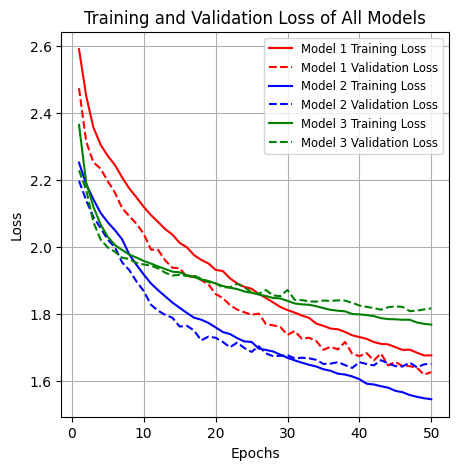

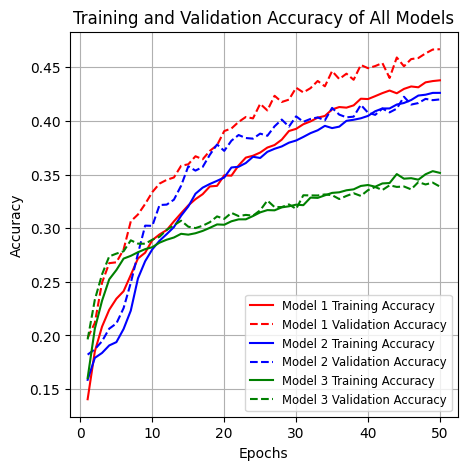

In [16]:

plt.figure(figsize=(5, 5)) 
color=['red', 'blue', 'green']
for i, hist in history.items():
    epochs = range(1, len(hist.history['loss']) + 1)
    
    plt.plot(epochs, hist.history['loss'], label=f'Model {i+1} Training Loss', color=color[i])
    plt.plot(epochs, hist.history['val_loss'], label=f'Model {i+1} Validation Loss', linestyle='--', color=color[i])

plt.title('Training and Validation Loss of All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='small')
plt.grid()
plt.show()


plt.figure(figsize=(5, 5)) 

for i, hist in history.items():
    epochs = range(1, len(hist.history['accuracy']) + 1)
    
    plt.plot(epochs, hist.history['accuracy'], label=f'Model {i+1} Training Accuracy', color=color[i])
    plt.plot(epochs, hist.history['val_accuracy'], label=f'Model {i+1} Validation Accuracy', linestyle='--', color=color[i])

plt.title('Training and Validation Accuracy of All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize='small')
plt.grid()
plt.show()

# 2.Random Search on CNN

After comparing different hyperparameters, we use random search to find 3 best-performing hyperparameter sets.

Build up configuration space.

In [10]:
def get_hyperparameter_search_space():
    cs = ConfigSpace.ConfigurationSpace()
    dropout = ConfigSpace.CategoricalHyperparameter(name='dropout', choices=['t', 'f'], default_value='t')
    keep_prop_rate = ConfigSpace.UniformFloatHyperparameter('keep_prop_rate', lower=0.2, upper=0.4, default_value=0.2)
    regularization_param = ConfigSpace.UniformFloatHyperparameter('regularization_param', 0.0001, 0.001, log=True, default_value=0.0001)
    batch_size = ConfigSpace.UniformIntegerHyperparameter('batch_size', 16, 128, default_value=32)
    dense_num = ConfigSpace.UniformIntegerHyperparameter('dense_num', 64, 512, default_value=64)
    lay_num = ConfigSpace.UniformIntegerHyperparameter('lay_num', 1, 5, default_value=3)
    kernel_initializer = ConfigSpace.CategoricalHyperparameter('kernel_initializer', ['he_uniform', 'he_normal', 'glorot_uniform'], default_value='glorot_uniform')
    optimizer = ConfigSpace.CategoricalHyperparameter('optimizer', ['rmsprop', 'sgd', 'adam'], default_value='adam')
    conv_filters = ConfigSpace.UniformIntegerHyperparameter('conv_filters', lower=16, upper=64, default_value=32)
    kernel_size = ConfigSpace.UniformIntegerHyperparameter('kernel_size', lower=3, upper=5, default_value=3)
    conv_layer_num = ConfigSpace.UniformIntegerHyperparameter('conv_layer_num', lower=1, upper=3, default_value=2)
    learning_rate = ConfigSpace.UniformFloatHyperparameter('learning_rate', lower=0.0001, upper=0.01, log=True, default_value=0.001)


    cs.add([batch_size, dense_num, lay_num, regularization_param, dropout, keep_prop_rate,
                            kernel_initializer, optimizer, conv_filters, kernel_size, conv_layer_num, learning_rate])

    rate_depends_on_dropout = ConfigSpace.EqualsCondition(keep_prop_rate, dropout, 't')
    cs.add(rate_depends_on_dropout)

    return cs

CNN model

In [18]:
import numpy as np
import time
import keras

class CNNModel:
    def __init__(self, config, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.config = config
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.optimizer = None
        self.model = self.build_model()


    def evaluate(self):
        performance = self.model.evaluate(self.X_test, self.y_test)[1]
        return performance


    def build_model(self):
        start_time = time.time()
        model = keras.models.Sequential()
        model.add(keras.layers.Conv2D(
            filters=self.config['conv_filters'],
            kernel_size=self.config['kernel_size'],
            activation='relu',
            input_shape=(28, 28, 1)
        ))

        for _ in range(self.config['conv_layer_num']):
            model.add(keras.layers.Conv2D(
                filters=self.config['conv_filters'],
                kernel_size=self.config['kernel_size'],
                activation='relu'
            ))

        model.add(keras.layers.Flatten())
        for _ in range(self.config['lay_num']):
            dense_num = int(np.random.random() * self.config['dense_num'])
            model.add(keras.layers.Dense(dense_num, activation='relu',
                                         kernel_initializer=self.config['kernel_initializer'],
                                         kernel_regularizer=keras.regularizers.l2(self.config['regularization_param'])))
            if self.config['dropout'] == 't':
                model.add(keras.layers.Dropout(self.config['keep_prop_rate']))

        model.add(keras.layers.Dense(10, activation='softmax'))


        if self.config['optimizer'] == 'rmsprop':
            self.optimizer = keras.optimizers.RMSprop(learning_rate=self.config['learning_rate'])
        elif self.config['optimizer'] == 'adam':
            self.optimizer = keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        else:
            self.optimizer = keras.optimizers.SGD(learning_rate=self.config['learning_rate'])


        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.optimizer,
                      metrics=['accuracy'])


        model.fit(self.X_train, self.y_train,
                  batch_size=self.config['batch_size'],
                  epochs=30,
                  validation_data=(self.X_valid, self.y_valid))

        return model

def default(cs, config):
    for hp in list(cs.values()):
        if hp.name not in config.keys():
            config[hp.name] = hp.default_value

In [19]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1)

cs = get_hyperparameter_search_space()

best_configs = []
best_performances = []
best_model = []
iteration_num = 10
for i in range(3):
    best_performance = -np.inf
    best_config = {}
    for j in range(iteration_num):
        config = dict(cs.sample_configuration(size=None))
        default(cs, config)
        model = CNNModel(config, X_train, y_train, X_valid, y_valid, X_test, y_test)
        performance = model.evaluate()
        if performance>best_performance:
            best_config = config
            best_performance = performance
    best_model.append(model)
    best_performances.append(best_performance)
    best_configs.append(best_config)

for i in range(len(best_configs)):
    print(best_configs[i])
print(best_performances)

Epoch 1/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3743 - loss: 3.7362 - val_accuracy: 0.7210 - val_loss: 2.6142
Epoch 2/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7511 - loss: 2.5426 - val_accuracy: 0.7727 - val_loss: 2.4805
Epoch 3/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7869 - loss: 2.4321 - val_accuracy: 0.7800 - val_loss: 2.4414
Epoch 4/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8033 - loss: 2.3887 - val_accuracy: 0.8232 - val_loss: 2.3559
Epoch 5/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8187 - loss: 2.3527 - val_accuracy: 0.8210 - val_loss: 2.3394
Epoch 6/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8242 - loss: 2.3243 - val_accuracy: 0.8173 - val_loss: 2.3311
Epoch 7/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8343 - loss: 2.3041 - val_accuracy: 0.8263 - val_loss: 2.3131
Epoch 8/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8361 - loss: 2.2860 - val_accuracy: 

{'batch_size': 86, 'conv_filters': 58, 'conv_layer_num': 3, 'dense_num': 182, 'dropout': 't', 'kernel_initializer': 'he_uniform', 'kernel_size': 4, 'lay_num': 4, 'learning_rate': 0.0011153481085, 'optimizer': 'rmsprop', 'regularization_param': 0.0004285305778, 'keep_prop_rate': 0.2881900532343}





{'batch_size': 114, 'conv_filters': 41, 'conv_layer_num': 2, 'dense_num': 439, 'dropout': 't', 'kernel_initializer': 'he_normal', 'kernel_size': 4, 'lay_num': 2, 'learning_rate': 0.0021711460824, 'optimizer': 'rmsprop', 'regularization_param': 0.0002546832188, 'keep_prop_rate': 0.2161377468806}





{'batch_size': 98, 'conv_filters': 32, 'conv_layer_num': 1, 'dense_num': 256, 'dropout': 'f', 'kernel_initializer': 'he_normal', 'kernel_size': 3, 'lay_num': 4, 'learning_rate': 0.0003705821721, 'optimizer': 'rmsprop', 'regularization_param': 0.000481956921, 'keep_prop_rate': 0.2}



#### are three best-performing hyperparameter sets, with accuracies of



[0.9153000116348267, 0.9057999849319458, 0.9099000096321106]

take the 3 best ones and train new models on the CIFAR-10 dataset.

1. import data

In [18]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32')/255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [21]:
y_train = keras.utils.to_categorical(y_train, 10)
y_val= keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_train.shape)

(32000, 10)


2. Use best-performing configuration.

In [22]:
config_data = [
    {'batch_size': 86, 'conv_filters': 58, 'conv_layer_num': 3, 'dense_num': 182, 'dropout': 't', 'kernel_initializer': 'he_uniform', 'kernel_size': 4, 'lay_num': 4, 'learning_rate': 0.0011153481085, 'optimizer': 'rmsprop', 'regularization_param': 0.0004285305778, 'keep_prop_rate': 0.2881900532343},
    {'batch_size': 114, 'conv_filters': 41, 'conv_layer_num': 2, 'dense_num': 439, 'dropout': 't', 'kernel_initializer': 'he_normal', 'kernel_size': 4, 'lay_num': 2, 'learning_rate': 0.0021711460824, 'optimizer': 'rmsprop', 'regularization_param': 0.0002546832188, 'keep_prop_rate': 0.2161377468806},
    {'batch_size': 98, 'conv_filters': 32, 'conv_layer_num': 1, 'dense_num': 256, 'dropout': 'f', 'kernel_initializer': 'he_normal', 'kernel_size': 3, 'lay_num': 4, 'learning_rate': 0.0003705821721, 'optimizer': 'rmsprop', 'regularization_param': 0.000481956921, 'keep_prop_rate': 0.2}
]

Build up model

In [23]:
history={}
for i, config in enumerate(config_data):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(
        filters=config['conv_filters'],
        kernel_size=(config['kernel_size'], config['kernel_size']),
        activation='relu',
        input_shape=(32, 32, 3)
    ))

    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    for _ in range(config['conv_layer_num']):
        model.add(keras.layers.Conv2D(
            filters=config['conv_filters'],
            kernel_size=(config['kernel_size'], config['kernel_size']),
            padding='same',
            activation='relu'
        ))

        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
         
    model.add(keras.layers.Flatten())
    for _ in range(config['lay_num']):
        dense_num = int(np.random.random() * config['dense_num'])
        model.add(keras.layers.Dense(dense_num, activation='relu',
                                     kernel_initializer=config['kernel_initializer'],
                                     kernel_regularizer=keras.regularizers.l2(config['regularization_param'])))

        if config['dropout'] == 't':
            model.add(keras.layers.Dropout(config['keep_prop_rate']))
    model.add(keras.layers.Dense(10, activation='softmax'))
    if config['optimizer'] == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])
    else:
        optimizer = keras.optimizers.SGD(learning_rate=config['learning_rate'])
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history[i] = model.fit(
        x_train, y_train,
        batch_size=config['batch_size'],
        epochs=20,
        verbose=1,
        validation_data=(x_val, y_val)

    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.1370 - loss: 2.5020 - val_accuracy: 0.2368 - val_loss: 2.0610
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2691 - loss: 1.9939 - val_accuracy: 0.3986 - val_loss: 1.6722
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3903 - loss: 1.7234 - val_accuracy: 0.4036 - val_loss: 1.7625
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4645 - loss: 1.5348 - val_accuracy: 0.5246 - val_loss: 1.3946
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5354 - loss: 1.3816 - val_accuracy: 0.4821 - val_loss: 1.6279
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5824 - loss: 1.2661 - val_accuracy: 0.5455 - val_loss: 1.5228
Epoch 7/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6155 - loss: 1.1721 - val_accuracy: 0.4851 - val_loss: 1.7352
Epoch 8/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6567 - loss: 1.0745 - val_accuracy: 

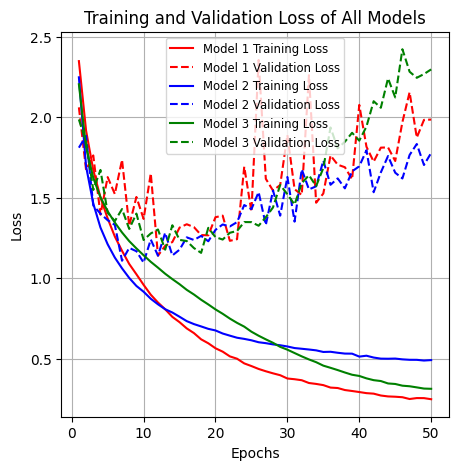

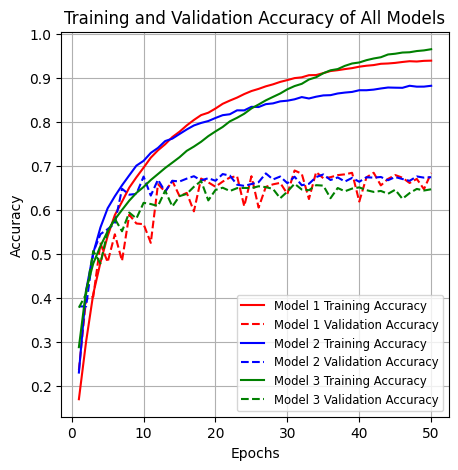

In [24]:
plt.figure(figsize=(5, 5)) 
color=['red', 'blue', 'green']
for i, hist in history.items():
    epochs = range(1, len(hist.history['loss']) + 1)
    
    plt.plot(epochs, hist.history['loss'], label=f'Model {i+1} Training Loss', color=color[i])
    plt.plot(epochs, hist.history['val_loss'], label=f'Model {i+1} Validation Loss', linestyle='--', color=color[i])

plt.title('Training and Validation Loss of All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='small')
plt.grid()
plt.show()


plt.figure(figsize=(5, 5)) 

for i, hist in history.items():
    epochs = range(1, len(hist.history['accuracy']) + 1)
    
    plt.plot(epochs, hist.history['accuracy'], label=f'Model {i+1} Training Accuracy', color=color[i])
    plt.plot(epochs, hist.history['val_accuracy'], label=f'Model {i+1} Validation Accuracy', linestyle='--', color=color[i])

plt.title('Training and Validation Accuracy of All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize='small')
plt.grid()
plt.show()
